In [ ]:
!pip install --quiet scanpy

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData

Loading dataframes

In [9]:
#ROIS annotations
rois_df = pd.read_csv("sample_anotations.txt",sep='\t')
rois_df = rois_df.loc[:,'SlideName':'NormalizationFactor']
rois_df = rois_df.set_index("SegmentDisplayName")

#Raw gene count
gene_raw_count_df = pd.read_csv("Kidney_Raw_TargetCountMatrix.txt",sep='\t')
gene_raw_count_df = gene_raw_count_df.set_index("TargetName").T

Merging and Adapting to AnnData format

In [17]:
def df_to_anndata(gene_raw_count_df,rois_df):
    """
    gene_raw_count_df:
        index: observation id
        columns: genes id
    rois_df:
        index:observation id
        columns: observation features
    """

    first_gene_id = gene_raw_count_df.columns[0]
    last_roi_var = rois_df.columns[-1]

    formated_data = pd.merge(rois_df,gene_raw_count_df,
                             left_index=True,right_index=True)

    #Matrix of observation*variables--ROI*gene
    X = formated_data.loc[:,first_gene_id:].to_numpy()

    #DataFrame indexed by genes id
    var = list(formated_data.head(1).loc[:,first_gene_id:].columns)
    var = pd.DataFrame(index=var)

    #DataFrame indexed by observations(ROI) identifiers
    obs = formated_data.loc[:,:last_roi_var]

    #Packaged data
    adata = AnnData(X,var=var,obs=obs)
    return adata

In [40]:
def rank_genes(adata,groupby=None,treat=None,n_samples=500):
    """
    input: anndata object
    """
    #Normalizing inside each roi
    sc.pp.normalize_total(adata, target_sum=1e4)
    #Natural log
    sc.pp.log1p(adata)
    
    #Hypothesis testing, samples: rois, control:normal,treat:dkd
    sc.tl.rank_genes_groups(adata,groupby=groupby,method='wilcoxon')
    
    #Formats conversion
    ranked_genes = pd.DataFrame()
    for var in ['pvals_adj','logfoldchanges','names']:
        ranked_genes[var] = adata.uns['rank_genes_groups'][var][treat]

    ranked_genes["-log_padj"] = -np.log10(ranked_genes.pvals_adj)

    #Under-sampling low scored genes
    ranked_genes["hue"] = ranked_genes["-log_padj"]*ranked_genes["logfoldchanges"]
    ranked_genes["weights"] = ranked_genes.hue**2
    ranked_genes = ranked_genes.sample(n=n_samples,weights='weights')
    
    return ranked_genes


In [41]:
adata = df_to_anndata(gene_raw_count_df,rois_df)
ranked_genes = rank_genes(adata,groupby='disease_status',treat='DKD',n_samples=500)
selected_genes = ranked_genes[ranked_genes.weights>ranked_genes["weights"].quantile(0.97)]

... storing 'SlideName' as categorical
... storing 'ScanName' as categorical
... storing 'SegmentLabel' as categorical
... storing 'disease_status' as categorical
... storing 'pathology' as categorical
... storing 'region' as categorical


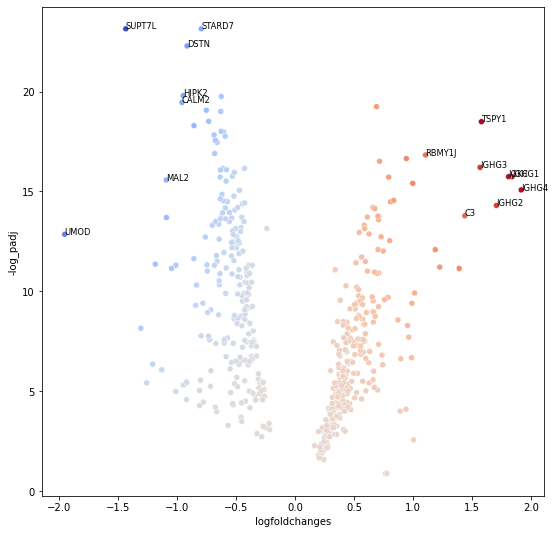

In [36]:
plt.figure(figsize=(9,9))
sns.scatterplot(data=ranked_genes,x='logfoldchanges',y="-log_padj",hue='hue',
                palette='coolwarm',legend=False)

#Annotating graph
for i,row in selected_genes.iterrows():
    y = row["-log_padj"]
    x = row["logfoldchanges"]
    gene_id = row["names"]
    plt.text(x, y, gene_id, horizontalalignment='left', size='small', color='black', weight='normal')

In [ ]:
#Exported code

In [69]:
def volcano_plot(adata):
    ranked_genes = rank_genes(adata,groupby='disease_status',treat='DKD',n_samples=500)
    
    fig = px.scatter(
               ranked_genes,
               x='logfoldchanges',
               y="-log_padj",
               color='logfoldchanges',
               color_continuous_scale='IceFire',
               hover_name='names',
               hover_data={'hue':False,
                          'logfoldchanges':False,
                          '-log_padj':False},
              )
    fig.update(layout_coloraxis_showscale=False)
    return 

In [67]:
px.scatter?